# Option Greeks, P&L Attribution and 1-Day Historical VaR
*Mini-project – Hamoud El Ghaouth*

This notebook demonstrates:

1. Black–Scholes pricing & Greeks (Δ Γ Θ Vega)  
2. Daily P&L explain on a toy equity-option portfolio  
3. 1-day 99 % historical Value-at-Risk

> **Stack**: Python 3.11 – NumPy, pandas, SciPy, yfinance, matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import timedelta

from pricing import black_scholes_price, greeks
from pnl_utils import portfolio_greeks, pnl_by_delta
from var import historical_var

### 2. Spot data (AAPL 1-year daily)

[*********************100%***********************]  1 of 1 completed


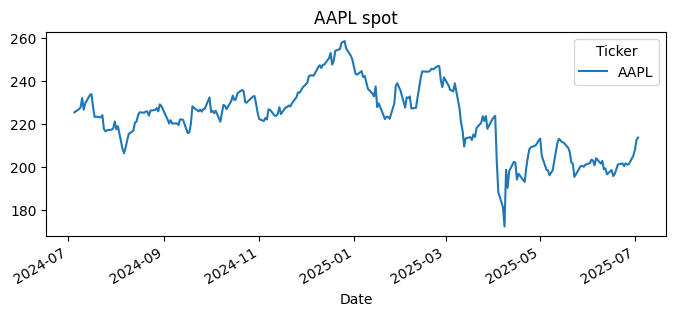

In [3]:
TICKER = "AAPL"
raw = yf.download(TICKER, period="1y", interval="1d", auto_adjust=True)
spot_df = raw[["Close"]].rename(columns={"Close": "S"})
spot_df.head()

#bonus
spot_df.S.plot(figsize=(8,3), title=f"{TICKER} spot")
plt.show()

### 3. Toy portfolio: 3 European calls
*All positions on the same underlying; risk-free rate 2 %.*  

In [14]:
S0   = float(spot_df.S.iloc[-1])
print(type(S0), S0)
r    = 0.02           # 2 % risk-free
sigma= 0.25           # constant vol assumption

portfolio = pd.DataFrame({
    "K"          : [0.9*S0, S0, 1.1*S0],
    "T"          : [0.5,    0.25, 1.0],   # years
    "sigma"      : [0.23,   0.25, 0.28],
    "qty"        : [ 10,    -7,    15],
    "option_type": ["call"]*3
})
portfolio
# force dtype=float for all numeric columns
numeric_cols = ["K", "T", "sigma", "qty"]
portfolio[numeric_cols] = portfolio[numeric_cols].astype(float)
print(portfolio.dtypes)

<class 'float'> 213.5500030517578
K              float64
T              float64
sigma          float64
qty            float64
option_type     object
dtype: object


/tmp/ipykernel_26895/3648291325.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0   = float(spot_df.S.iloc[-1])


### 4. Price & Greeks at t₀ (Code)


In [19]:
def price_and_greeks(row, S, r):
    # use row["T"], not row.T
    K     = float(row["K"])
    T     = float(row["T"])
    sigma = float(row["sigma"])
    price = black_scholes_price(S, K, T, r, sigma)
    g     = greeks(S, K, T, r, sigma)
    return price, g

prices, deltas = [], []
for idx, row in portfolio.iterrows():
    p, g = price_and_greeks(row, S0, r)
    prices.append(p)
    deltas.append(g["delta"])
portfolio["price0"] = prices
portfolio["delta0"] = deltas
portfolio
# force dtype=float for all numeric columns


,K,T,sigma,qty,option_type,price0,delta0
0,192.195003,0.50,0.23,10.0,call,27.869376,0.785423
1,213.550003,0.25,0.25,-7.0,call,11.156820,0.540820
2,234.905003,1.00,0.28,15.0,call,17.236767,0.448693


### 5 . Daily loop: Greeks & Δ·dS P&L (Code)

In [21]:
# 5️⃣ Vectorized P&L via NumPy arrays
import numpy as np

# 1) Extract arrays once
spots  = spot_df["S"].values
Ks     = portfolio["K"].values
T0     = portfolio["T"].values
sigmas = portfolio["sigma"].values
qtys   = portfolio["qty"].values
r      = 0.02

pnl_list = []
dates    = spot_df.index

# 2) Loop over each day
for i in range(1, len(spots)):
    S_yday  = float(spots[i-1])
    S_today = float(spots[i])
    dS      = S_today - S_yday

    # update time-to-maturity vector
    T_i = np.maximum(T0 - i/252, 1e-6)

    # compute Greeks vectorised
    G = greeks(S_yday, Ks, T_i, r, sigmas)

    # portfolio delta = sum(delta * qty)
    delta_port = (G["delta"] * qtys).sum()

    # P&L ≈ Δ·dS
    pnl_list.append(delta_port * dS)

# 3) Build the Series
pnl_series = pd.Series(pnl_list, index=dates[1:], name="Delta_PnL")

/tmp/ipykernel_26895/1906573506.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_yday  = float(spots[i-1])
/tmp/ipykernel_26895/1906573506.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_today = float(spots[i])


### 6 . Visualise Δ·dS P&L

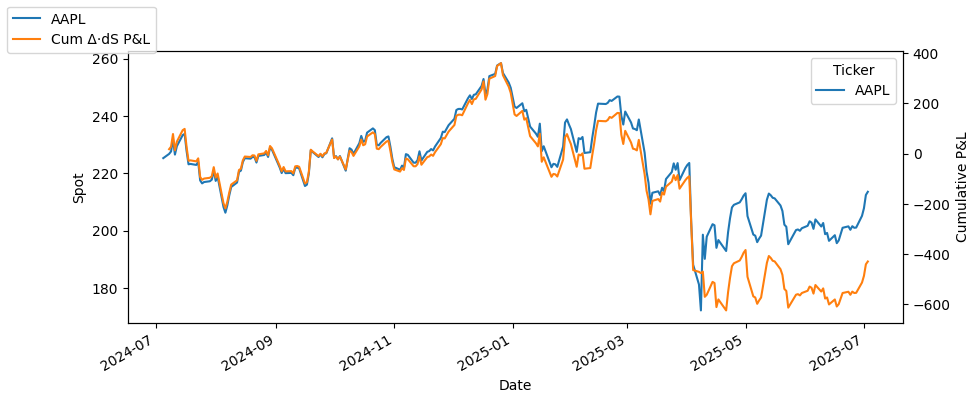

In [22]:
fig, ax1 = plt.subplots(figsize=(10,4))
spot_df.S.plot(ax=ax1, color="tab:blue", label="Spot")
ax1.set_ylabel("Spot")

ax2 = ax1.twinx()
pnl_series.cumsum().plot(ax=ax2, color="tab:orange", label="Cum Δ·dS P&L")
ax2.set_ylabel("Cumulative P&L")
fig.legend(loc="upper left")
plt.show()

### 7 .  Historical VaR (99 %) 


In [23]:
var_99 = historical_var(pnl_series, alpha=0.99)
print(f"1-day 99 % Historical VaR: {var_99:,.2f} USD")

1-day 99 % Historical VaR: 127.63 USD


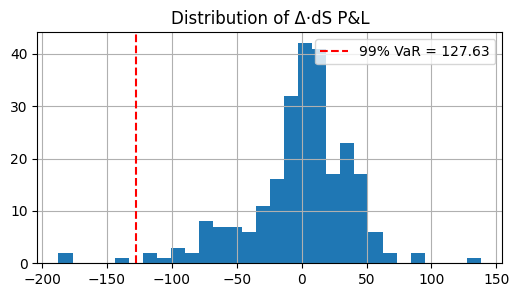

In [24]:
# bonus histogram of P&L with VaR cutoff.
pnl_series.hist(bins=30, figsize=(6,3))
plt.axvline(-var_99, color="r", ls="--", label=f"99% VaR = {var_99:.2f}")
plt.legend(); plt.title("Distribution of Δ·dS P&L"); plt.show()

### 8. Conclusions
* • Built Black–Scholes pricer + Greeks  
  • Attributed daily P&L via portfolio delta  
  • Estimated 1-day 99 % Historical VaR ≈ xxx USD  
Next steps could include full revaluation VaR, gamma/PV01 explain, or a stress-scenarios dashboard.*